In [1]:
import torch
import numpy as np
from torchrl.envs import VmasEnv
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs import check_env_specs
from random import sample
from matplotlib import pyplot as plt
from collections import deque as Deque
from rich.console import Console
from rich.table import Table
from rich.live import Live
from itertools import count

# Create the Environment

In [2]:
scenario_name = "football"
max_steps = 1_000
n_agents = 3
device = vmas_device = "cuda" if torch.cuda.is_available() else "cpu"


env = VmasEnv(
    scenario=scenario_name,
    num_envs=1,
    continuous_actions=True,
    max_steps=max_steps,
    device=vmas_device,
    n_red_agents=n_agents,
    n_blue_agents=n_agents,
    agent_size=0.05,
    ball_size=0.03,
    max_speed=3,
    u_multiplier=1,
    goal_depth=0.2,
    ai_red_agents=True,
    ai_blue_agents=False,
    dense_reward_ratio=0.75,
    viewer_size=(640, 480),
    pitch_length=1.5,
    pitch_width=0.75,
    max_ball_dist_reward=3.0
)

# env.max_ball_dist_reward = 2.0

# The AI is RED (AI -> Actually a RULE-BASED algorithm)
# The Multi-Agent System is BLUE

env = TransformedEnv(env, RewardSum())

In [3]:
check_env_specs(env=env)

2024-11-27 16:39:19,909 [torchrl][INFO] check_env_specs succeeded!


In [4]:
def create_action(action_values: torch.Tensor):
    action = env.rand_action()
    action.set(env.action_key, action_values.reshape(action[env.action_key].shape))
    return action

# Create Networks

## Policy Network

In [5]:
class ActorNetwork(torch.nn.Module):
    _network: torch.nn.Sequential
    _max_action: float
    _state_dims: int
    _action_dims: int

    def __init__(
        self, state_dims: int, action_dims: int, n_agents: int, max_action: float
    ) -> None:
        super().__init__()
        self._state_dims = state_dims * n_agents
        self._action_dims = action_dims * n_agents
        self._max_action = max_action
        self._network = torch.nn.Sequential(
            torch.nn.Linear(self._state_dims, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self._action_dims),
            torch.nn.Tanh(),
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return (
            self._network(state.reshape(state.shape[0], self._state_dims))
            * self._max_action
        )

    def get_action(self, state: torch.Tensor):
        action_values = self.forward(state=state)
        return create_action(action_values.reshape((-1, 3, 2)))

## Critic Network

In [6]:
class QNetwork(torch.nn.Module):
    _network: torch.nn.Sequential
    _max_action: float
    _state_dims: int
    _action_dims: int

    def __init__(
        self, state_dims: int, action_dims: int, n_agents: int, max_action: float
    ) -> None:
        super().__init__()
        self._state_dims = state_dims * n_agents
        self._action_dims = action_dims * n_agents
        self._max_action = max_action
        self._network = torch.nn.Sequential(
            torch.nn.Linear(self._state_dims + self._action_dims, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            # torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
        )

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.concat(tensors=(state.flatten(1), action.flatten(1)), dim=1)
        return self._network(x)

## Initialize the Networks

- Init networks
- Copy weights into targets

In [7]:
actor_net = ActorNetwork(
    state_dims=8, action_dims=2, n_agents=n_agents, max_action=1
).to(device)
q_net = QNetwork(state_dims=8, action_dims=2, n_agents=n_agents, max_action=1).to(
    device
)

actor_target = ActorNetwork(
    state_dims=8, action_dims=2, n_agents=n_agents, max_action=1
).to(device)
q_target = QNetwork(state_dims=8, action_dims=2, n_agents=n_agents, max_action=1).to(
    device
)

actor_target.load_state_dict(actor_net.state_dict())
q_target.load_state_dict(q_net.state_dict())

<All keys matched successfully>

# Utils

## Update the target network weights

In [8]:
def update_target_nets(
    q_net: torch.nn.Module,
    q_target: torch.nn.Module,
    actor_net: torch.nn.Module,
    actor_target: torch.nn.Module,
    tau: float = 0.002
) -> None:
    for var, var_target in zip(q_net.parameters(), q_target.parameters()):
        var_target.data = var * tau + (1.0 - tau) * var_target.data
    for var, var_target in zip(actor_net.parameters(), actor_target.parameters()):
        var_target.data = var * tau + (1.0 - tau) * var_target.data

## Add Random Noise to Actions

In [9]:
def add_random_noise(
    action: torch.Tensor, min_noise: float = -0.1, max_noise: float = 0.1
):
    noise = torch.rand(action.shape, device=device) * (max_noise - min_noise) + min_noise
    return torch.clip(action + noise, min=-1.0, max=1.0)

## Create a table to log some values

Some important values to log include:
- Output of the Q-Network for current state and action pair, $\hat{Q}_{\theta_{\text{critic}}}(s, a)$
- Actions predicted by the actor network for current state, $\hat{\mu}_{\theta_{\text{actor}}}(s)$
- The reward for the current step, $R$
- The loss for the actor model, $\mathcal{L}_{\text{actor}}(\theta_{\text{actor}})$
- The loss for the critic model, $\mathcal{L}_{\text{critic}}(\theta_{\text{critic}})$

In [10]:
def create_table(
    episode: int | None = None,
    t: int | None = None,
    q: torch.Tensor | None = None,
    u: torch.Tensor | None = None,
    r: torch.Tensor | None = None,
    l_actor: torch.Tensor | None = None,
    l_critic: torch.Tensor | None = None,
    noise: float | None = None,
) -> Table:
    """
    Creates a Rich table for displaying RL model parameters.

    Args:
        episode (int): The current episode number.
        t (int): The current timestep within the episode.
        q (torch.Tensor): The Q-value for the current state-action pair.
        u (torch.Tensor): The policy's action distribution (μ) for the current state.
        r (torch.Tensor): The reward at the current timestep.
        l_actor (torch.Tensor): The actor loss.
        l_critic (torch.Tensor): The critic loss.
        noise (float): The noise added to the actions.

    Returns:
        Table: A Rich table object displaying the parameters.
    """
    table = Table(title="Model Parameters", show_header=True, header_style="bold green")
    table.add_column("Parameter", justify="left", style="cyan", no_wrap=True)
    table.add_column("Value", justify="left", style="magenta")

    # Add rows for each parameter
    table.add_row("episode", str(episode))
    table.add_row("t", str(t))
    table.add_row("Q(s, a)", str(q))
    table.add_row("μ(s, a)", str(u))  # Unicode character for μ
    table.add_row("R", str(r), style="bold blue")
    table.add_row("L_actor", str(l_actor))
    table.add_row("L_critic", str(l_critic))
    table.add_row("noise", str(noise))
    table.add_row(
        "agent pos",
        str(torch.cat([agent.state.pos for agent in env.world.policy_agents], dim=0)),
    )

    return table

# Training Loop

## Define the Hyperparameters

In [11]:
n_epochs = 20
batch_size = 32
should_update = False
min_buffer_items = 64
buffer_size = 256
n_updates = 128
gamma = 0.99
steps = 200

noise = 0.2
noise_decay = 5e-5

actor_lr = np.exp(-3)
q_lr = np.exp(-3)

tau = 0.005

## Create the Optimizers

- We use *Adam with weight decay*

In [12]:
actor_optim = torch.optim.Adam(actor_net.parameters(), lr=actor_lr)
q_optim = torch.optim.Adam(q_net.parameters(), lr=q_lr)

## The Real Sauce!!!

In [13]:
history = []
replay_buffer = Deque([], maxlen=buffer_size)
console = Console()

train = True

# console.log("Resetting env")
reset = env.reset()
state = reset.get(("agent_blue", "observation"))

with Live(create_table(noise=noise), refresh_per_second=5) as live:
    for episode in count() if train else range(n_epochs):
        # console.log("Entering 2nd loop")
        for t in range(steps):
            # console.log("Picking action")
            action = create_action(
                add_random_noise(actor_net(state), min_noise=-noise, max_noise=noise)
            )
            # action = create_action(actor_net(state))

            # print(action[env.action_key])

            # console.log("Taking step acc to action")
            step = env.step(action) if train else env.rand_step()
            # console.log("Getting observations")
            next_state = step.get(("next", "agent_blue", "observation"))
            reward = step.get(("next", "agent_blue", "reward"))
            done = step.get(("next", "done"))

            env.render()

            # Store transition in replay buffer
            # console.log("Appending to replay buffer")
            replay_buffer.append(
                (
                    state,
                    action[env.action_key],
                    reward,
                    next_state,
                    done,
                )
            )
            state = next_state

            # Reset the env if in terminal state
            if done:
                env.reset()

            # Time to update
            should_update = len(replay_buffer) > min_buffer_items
            if should_update and train:
                noise /= (1 + noise_decay)

                # Select random minibatch
                batch = sample(population=replay_buffer, k=batch_size)
                states, actions, rewards, next_states, dones = [
                    torch.cat(z, dim=0) for z in list(zip(*batch))
                ]
                rewards = rewards.squeeze(-1)

                qs = q_net(states, actions)
                pred_actions = actor_net(states).reshape(actions.shape)

                # Target y
                next_target_actions = actor_target(next_states)
                next_target_qs = q_target(next_states, next_target_actions)

                # console.log(
                #     {
                #         "next_target_actions": next_target_actions.shape,
                #         "next_target_qs": next_target_qs.shape,
                #         "dones": dones.shape,
                #         "rewards": rewards.shape,
                #     }
                # )

                y_target = (
                    rewards + gamma * (1 - dones.to(dtype=torch.float)) * next_target_qs
                )

                # Update Q network
                q_optim.zero_grad()
                q_loss_fn = (
                    torch.nn.MSELoss()
                )  # Update the current state to the next state
                q_loss = q_loss_fn(qs, y_target.mean(dim=1, keepdim=True))
                q_optim.step()
                for p in q_net.parameters():
                    p.requires_grad = True

                # Update Actor Network
                actor_optim.zero_grad()
                actor_loss = -q_net(states, pred_actions.detach())
                actor_loss.mean().backward(retain_graph=True)
                actor_optim.step()
                for p in actor_net.parameters():
                    p.requires_grad = True

                # Update target networks
                update_target_nets(
                    q_net=q_net,
                    q_target=q_target,
                    actor_net=actor_net,
                    actor_target=actor_target,
                    tau=tau,
                )

                history.append(
                    (
                        q_loss.detach().mean().cpu(),
                        actor_loss.detach().mean().cpu(),
                        rewards.detach().mean().cpu(),
                    )
                )

                # Update the live display logger
                live.update(
                    create_table(
                        episode=episode,
                        t=t,
                        # q=qs.detach().mean().cpu(),
                        u=action[env.action_key],
                        r=reward.mean(),
                        l_actor=q_loss.detach().mean(),
                        l_critic=actor_loss.detach().mean(),
                        noise=noise,
                    )
                )
            else:
                live.update(
                    create_table(
                        episode=episode,
                        t=t,
                        u=action[env.action_key],
                        r=reward.mean(),
                        noise=noise,
                    )
                )
                history.append((0, 0, reward.detach().mean().cpu()))

Output()

ArgumentError: argument 2: TypeError: 'NoneType' object cannot be interpreted as an integer

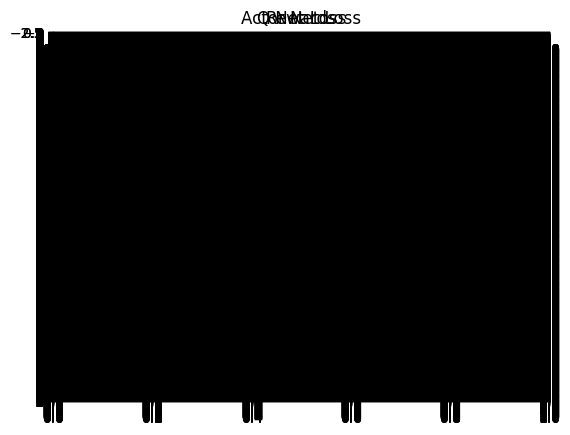

In [19]:
history = np.array(history).T
fig, ax = plt.subplots(nrows=history.shape[0], ncols=1)
window_size = 250


for ax_, title, hist in zip(ax, ["Q Net Loss", "Actor Net Loss", "Rewards"], history):
    ax_.set_title(title)
    ax_.plot(hist)
    ax_.plot(np.convolve(hist, np.ones(window_size) / window_size, mode="valid"))

In [20]:
history.mean(axis=1)

array([-0.6481005 , -0.80726782, -0.86253786, ...,  1.56628715,
        1.66019973,  1.27727104])

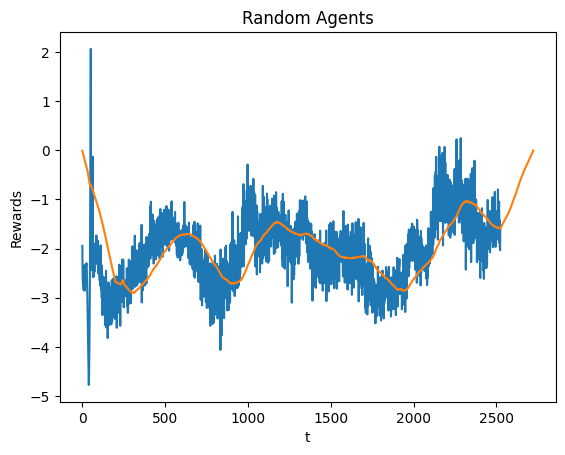

In [ ]:
plt.xlabel("t")
plt.ylabel("Rewards")
plt.title("Training Results")
plt.plot(history[2])
plt.plot(np.convolve(history[2], np.ones(200) / 200))

In [ ]:
ball_pos = env.world.ball.state.pos
agent_pos = torch.cat([agent.state.pos for agent in env.world.policy_agents], dim=0)
agent_ball_dists = torch.norm(agent_pos - ball_pos, dim=1)
dist_reward_max = 2.0
dist_reward = -torch.log(
    dist_reward_max * agent_ball_dists.min() + np.exp(-dist_reward_max)
)

agent_ball_dists, dist_reward

(tensor([0.5430, 0.7232, 1.3133], device='cuda:0'),
 tensor(-0.2000, device='cuda:0'))

In [ ]:
env.world.policy_agents[0].color

(0.25, 0.25, 0.75)